# Generate cross-correlation function between 2 given catalogs

In [1]:
import os
import tempfile
import time
import copy

import numpy as np
import scipy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, BoxSubsampler, project_to_wp, utils, setup_logging
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *

# To activate logging
setup_logging()

### Output directory

In [2]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

### Get halo catalog

In [3]:
# 1 Gpc/h
path_to_sim_1 = '/feynman/scratch/dphp/ar264273/Abacus/AbacusSummit_highbase_c000_ph100/halos/z1.175'

# 2 Gpc/h
path_to_sim_2_z1 = '/feynman/scratch/dphp/ar264273/Abacus/AbacusSummit_base_c000_ph000/halos/z1.175'
path_to_sim_2_z2 = '/feynman/scratch/dphp/ar264273/Abacus/AbacusSummit_base_c000_ph000/halos/z0.800'

path_to_sim = [path_to_sim_1,
               path_to_sim_2_z1,
               path_to_sim_2_z2]

catalog_names = ['AbacusSummit_highbase_c000_ph100_z1.175',
                 'AbacusSummit_base_c000_ph000_z1.175',
                 'AbacusSummit_base_c000_ph000_z0.800']

sim_z = [1.175, 1.175, 0.800]
sim_boxsizes = [1000, 2000, 2000]

# Simulation to use
sim_index = 1

# Whether to apply RSD or not
RSD = False
RSD_string = ''
if RSD:
    RSD_string = '_wRSD'

In [4]:
boxsize = sim_boxsizes[sim_index]
z = sim_z[sim_index]

In [5]:
# density split names
subset_names = ['D1', 'D2']
split_catalogs_meshes = list()
split_catalogs_positions = list()
split_catalogs_weights = list()
cellsize = 20
resampler = 'tsc'

for i in range(len(subset_names)):
    split_catalogs_meshes.append(np.load(output_dir+catalog_names[sim_index]+RSD_string+'_'+subset_names[i]+'_meshes_'+resampler+'.npy'))
    split_catalogs_positions.append(np.load(output_dir+catalog_names[sim_index]+RSD_string+'_'+subset_names[i]+'_positions_'+resampler+'.npy'))
    split_catalogs_weights.append(np.load(output_dir+catalog_names[sim_index]+RSD_string+'_'+subset_names[i]+'_weights_'+resampler+'.npy'))

In [6]:
catalog_positions = np.load(output_dir+catalog_names[sim_index]+RSD_string+'_positions.npy')
catalog_weights = np.load(output_dir+catalog_names[sim_index]+RSD_string+'_weights.npy')
data_size = np.shape(catalog_positions)[1]

### Generate random points within a specific area

In [7]:
# Generate random catalogs to compare catalog with when computing correlation function
def generate_catalog_in_area(area, size=10000, boxsize=(boxsize,)*3, offset=(boxsize,0.,0.), cellsize=1, nmesh=boxsize, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    nmesh = round(boxsize[0]/cellsize)
    positions_grid_indices = ((np.array(positions)+cellsize/2.) // cellsize).astype(int) % nmesh    
    positions_grid_indices[positions_grid_indices==nmesh] = nmesh-1
    positions_in_area = area[tuple(positions_grid_indices.tolist())]
    return np.array(positions).T[positions_in_area].T, np.array(positions).T[np.logical_not(positions_in_area)].T

randoms_positions = generate_catalog_in_area(split_catalogs_meshes[0], size=6*data_size, boxsize=(boxsize,)*3, offset=(0, 0, 0), cellsize=cellsize, seed=42)

### Split in subsamples for jackknife variance estimation

In [8]:
subsamplers = list()
labels = list()
data_samples = list()
randoms_samples = list()

for i in range(len(subset_names)):
    subsampler = BoxSubsampler(positions=split_catalogs_positions[i], boxsize=np.full(3, boxsize), boxcenter=np.full(3, boxsize/2.), nsamples=1e3)
    subsamplers.append(subsampler)
    labels.append(subsampler.label(positions=split_catalogs_positions[i]))
    data_samples.append(subsampler.label(split_catalogs_positions[i]))
    randoms_samples.append(subsampler.label(randoms_positions[i]))

In [9]:
np.min(split_catalogs_positions[i])

0.0

## Compute s-mu two point correlation function

### Correlation function of each density split

In [10]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

results = list()

for i in range(len(subset_names)):
    result = TwoPointCorrelationFunction('smu', edges, 
                                         data_positions1=split_catalogs_positions[i], #data_weights1 = split_catalogs_weights[i],
                                         randoms_positions1=randoms_positions[i],
                                         data_samples1 = data_samples[i], 
                                         randoms_samples1=randoms_samples[i],
                                         engine='corrfunc', nthreads=128,
                                         los = 'x')
    results.append(result)

    # save result
    result.save(output_dir+catalog_names[sim_index]+RSD_string+'_corrfunc_splitRandomx6_'+subset_names[i]+'_'+resampler)

[000067.47]  04-20 09:45  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_jackknife.JackknifeLandySzalayTwoPointEstimator'>.
[000067.47]  04-20 09:45  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000067.98]  04-20 09:45  numexpr.utils                INFO     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[000067.98]  04-20 09:45  numexpr.utils                INFO     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[000067.98]  04-20 09:45  numexpr.utils                INFO     NumExpr defaulting to 8 threads.
[000767.40]  04-20 09:56  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[005173.86]  04-20 11:10  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[014490.84]  04-20 13:45  JackknifeLandySzalayTwoPointEstimator INFO     Saving /feynman/work/dphp/mp270220/output

In [11]:
results_load = list()

for i in range(len(subset_names)):
    result = TwoPointCorrelationFunction.load(output_dir+catalog_names[sim_index]+RSD_string+'_corrfunc_splitRandomx6_'+subset_names[i]+'_'+resampler+'.npy')
    results_load.append(result)

[019980.45]  04-20 15:17  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_corrfunc_splitRandomx6_D1_tsc.npy.
[019983.13]  04-20 15:17  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_corrfunc_splitRandomx6_D2_tsc.npy.


In [12]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
nells = len(ells)

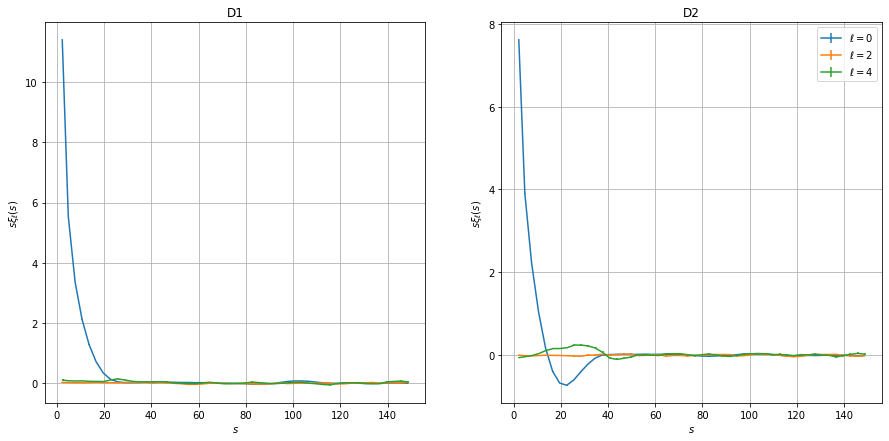

In [13]:
plt.rcParams["figure.figsize"] = (15, 7)
fig, axes = plt.subplots(1, 2)

for i in range(len(subset_names)):
    s, xiell, cov = results_load[i].get_corr(ells=ells, return_sep=True, return_cov=True)
    std = np.array_split(np.diag(cov)**0.5, nells)
    
    ax = axes[i]

    for ill,ell in enumerate(ells):
        ax.errorbar(s+ill*0.1, s * xiell[ill], s * std[ill], fmt='-', label='$\ell = {:d}$'.format(ell))
    ax.grid(True)
    ax.set_xlabel(r'$s$')
    ax.set_ylabel(r'$s \xi_{\ell}(s)$')
    ax.set_title(subset_names[i])

plt.legend()
plt.show()

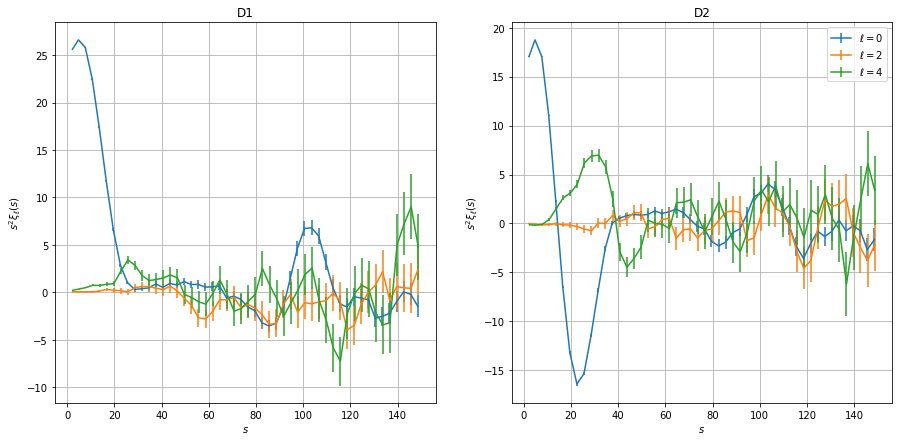

In [14]:
plt.rcParams["figure.figsize"] = (15, 7)
fig, axes = plt.subplots(1, 2)

for i in range(len(subset_names)):
    s, xiell, cov = results_load[i].get_corr(ells=ells, return_sep=True, return_cov=True)
    std = np.array_split(np.diag(cov)**0.5, nells)
    
    ax = axes[i]

    for ill,ell in enumerate(ells):
        ax.errorbar(s+ill*0.1, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='$\ell = {:d}$'.format(ell))
    ax.grid(True)
    ax.set_xlabel(r'$s$')
    ax.set_ylabel(r'$s^2 \xi_{\ell}(s)$')
    ax.set_title(subset_names[i])

plt.legend()
plt.show()